### Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("viridis"))

### Loading data

#### We are not going to use test.csv data, because it consists of train.csv data, and this can lead to data leak

In [2]:
train_df = pd.read_csv('train.csv', sep=';')
print(f"Dataset shape - {train_df.shape}")
train_df.head()

Dataset shape - (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
train_df = train_df.rename(columns={'y': 'target'})
train_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Prepare data for visualizing'

Copy training dataframe for manipulations during EDA

In [4]:
df = train_df.copy()
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


#### Transform binary category features to int

In [5]:
binary_columns = []
for column in df.select_dtypes('object').columns:
    if len(df[column].unique()) == 2:
        binary_columns.append(column)
    print(f"Column - {column} ",df[column].unique(), end='\n\n')

Column - job  ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Column - marital  ['married' 'single' 'divorced']

Column - education  ['tertiary' 'secondary' 'unknown' 'primary']

Column - default  ['no' 'yes']

Column - housing  ['yes' 'no']

Column - loan  ['no' 'yes']

Column - contact  ['unknown' 'cellular' 'telephone']

Column - month  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Column - poutcome  ['unknown' 'failure' 'other' 'success']

Column - target  ['no' 'yes']



In [6]:
for column in binary_columns:
    df[column] = df[column].map({'yes': 1, 'no': 0})
    
df.loc[:, binary_columns]

,default,housing,loan,target
0,0,1,0,0
1,0,1,0,0
2,0,1,1,0
3,0,1,0,0
4,0,0,0,0
...,...,...,...,...
45206,0,0,0,1
45207,0,0,0,1
45208,0,0,0,1
45209,0,0,0,0


##  EDA

### Target feature

Target variable is highly imbalanced, this will impact perfomance of a model, this can be fixed with SMOTE technique

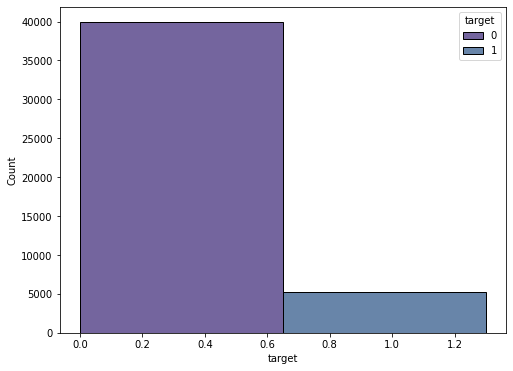

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="target", hue="target", multiple="dodge",binwidth=1.3)
plt.show()

### Education

Most clients have secondary education

Let's see how education impacts our target variable

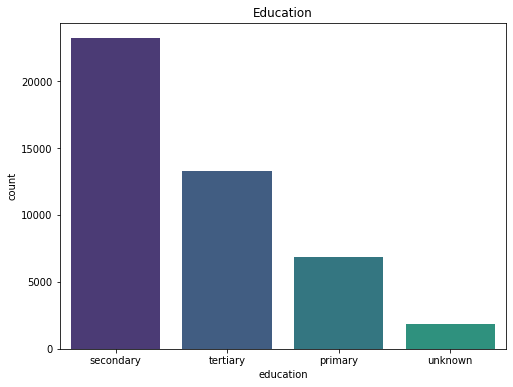

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'education',
              data = df,
              order = df['education'].value_counts().index)
plt.title('Education')
plt.show()

Even if we have more clients that have secondary education, by average clients who have tertiary have a positive target value.

So, in theory this can impact output of the model

In [9]:
education_target = df.groupby('education', as_index=False)['target']
education_target_mean = education_target.mean().sort_values(by='target', ascending=False)
education_target_sum = education_target.sum().sort_values(by='target', ascending=False)

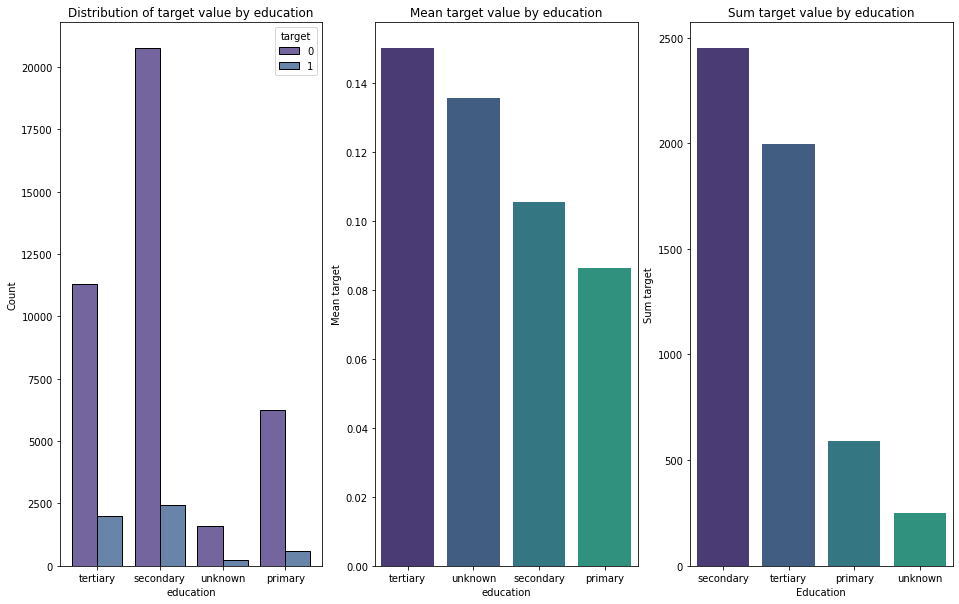

In [10]:
plt.figure(figsize=(16,10))
plt.subplot(1,3,1)
sns.histplot(data=df, x="education", hue="target", multiple="dodge",binwidth=1.1,shrink=.8)
plt.title('Distribution of target value by education')

plt.subplot(1,3,2)
sns.barplot(data=education_target_mean, x='education', y='target')
plt.xlabel("education")
plt.ylabel("Mean target")
plt.title("Mean target value by education")

plt.subplot(1,3,3)
sns.barplot(data=education_target_sum, x='education', y='target')
plt.xlabel("Education")
plt.ylabel("Sum target")
plt.title("Sum target value by education")

plt.show()

Also, clients who have secondary education and loan in average subscribe a term deposit more

This can also impact the results of model

In [11]:
education_group = df.groupby('education', as_index=False)
education_loan_mean = education_group['loan'].mean().sort_values(by='loan', ascending=False)
education_loan_sum = education_group['loan'].sum().sort_values(by='loan', ascending=False)

education_default_mean = education_group['default'].mean().sort_values(by='default', ascending=False)
education_default_sum = education_group['default'].sum().sort_values(by='default', ascending=False)

education_loan_mean

,education,loan
1,secondary,0.185458
0,primary,0.149467
2,tertiary,0.134125
3,unknown,0.071621


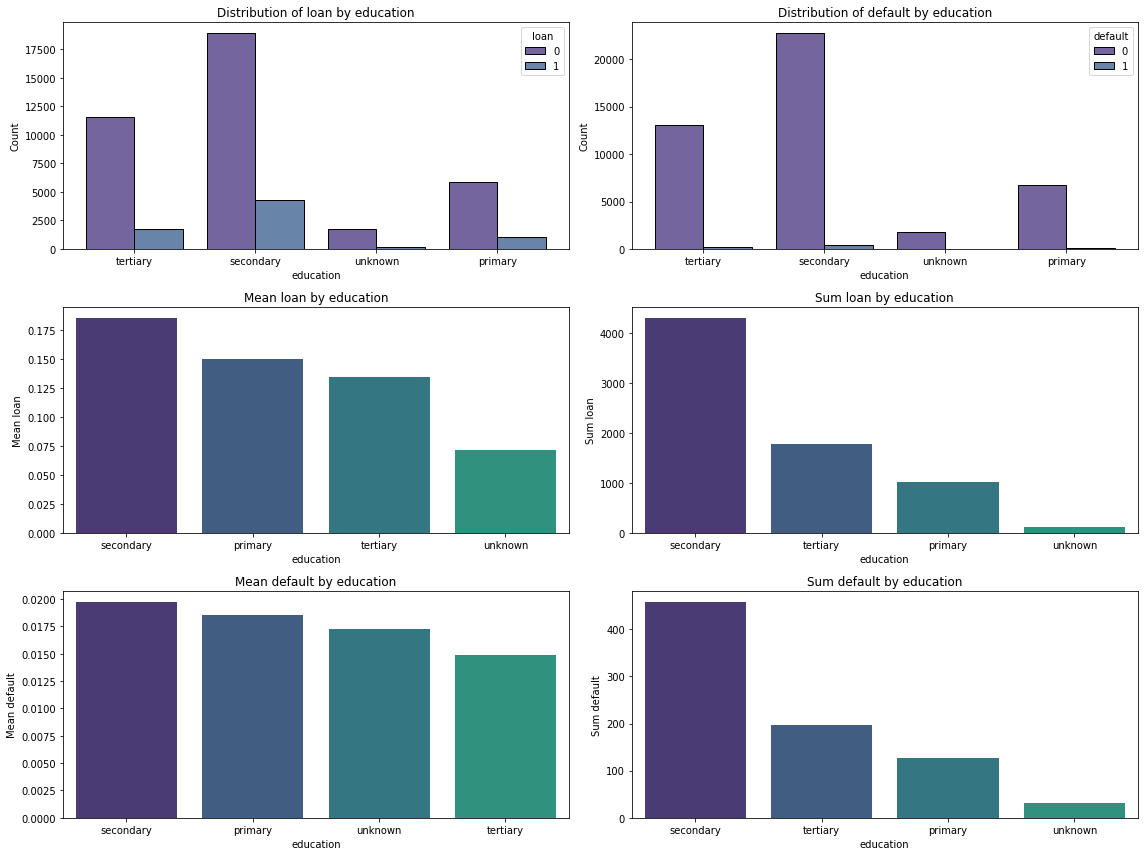

In [12]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)

sns.histplot(data=df, x="education", hue="loan", multiple="dodge",binwidth=1.1,shrink=.8)
plt.title('Distribution of loan by education')

plt.subplot(3,2,2)
sns.histplot(data=df, x="education", hue="default", multiple="dodge",binwidth=1.1,shrink=.8)
plt.title('Distribution of default by education')

plt.subplot(3,2,3)
sns.barplot(data=education_loan_mean, x='education', y='loan',)
plt.xlabel("education")
plt.ylabel("Mean loan")
plt.title("Mean loan by education")

plt.subplot(3,2,4)
sns.barplot(data=education_loan_sum, x='education', y='loan')
plt.xlabel("education")
plt.ylabel("Sum loan")
plt.title("Sum loan by education")

plt.subplot(3,2,5)
sns.barplot(data=education_default_mean, x='education', y='default')
plt.xlabel("education")
plt.ylabel("Mean default")
plt.title("Mean default by education")

plt.subplot(3,2,6)
sns.barplot(data=education_default_sum, x='education', y='default')
plt.xlabel("education")
plt.ylabel("Sum default")
plt.title("Sum default by education")
plt.tight_layout()
plt.show()

### Job

Most of the cliens have blue-collar, management or technician job

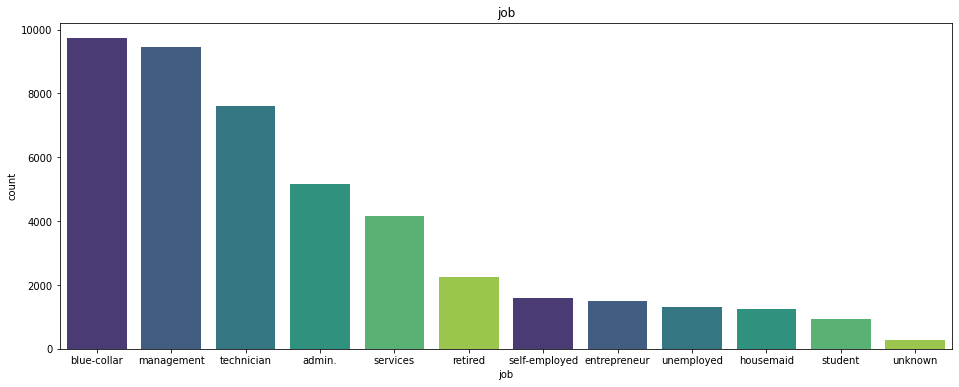

In [13]:
plt.figure(figsize=(16,6))
sns.countplot(x = 'job',
              data = df,
              order = df['job'].value_counts().index, palette=sns.color_palette('viridis'))
plt.title('job')
plt.show()

But, as we can see, in average students and retired clients subscribed for deposit more

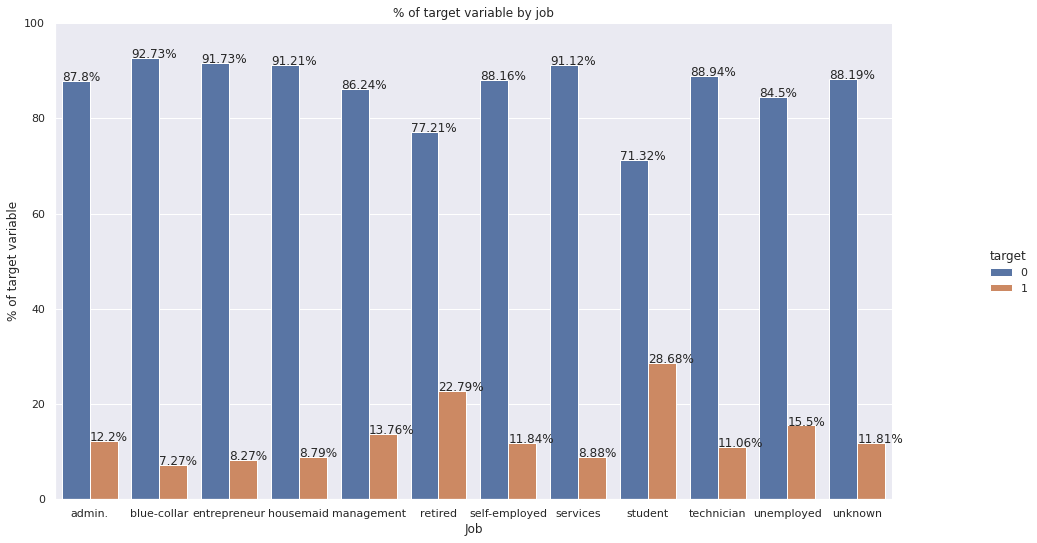

In [14]:
sns.set(rc={'figure.figsize':(16,18)})
x,y = 'job', 'target'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g= sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.figure.set_figheight(8)
g.figure.set_figwidth(16)
g.ax.set_ylim(0,100)
g.ax.set_xlabel('Job')
g.ax.set_ylabel('% of target variable')
g.ax.set_title("% of target variable by job")
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)




We have no high correlation between features

<AxesSubplot:>

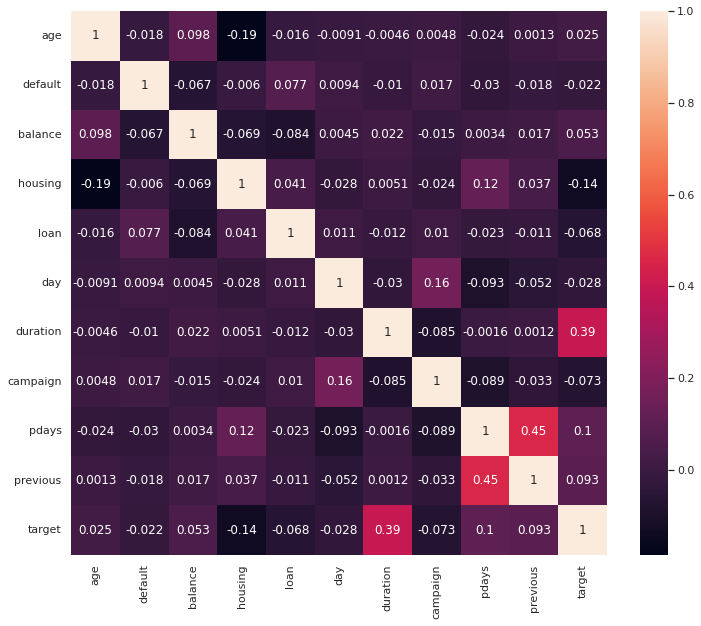

In [15]:
plt.figure(figsize=(12,10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot =True)

### Visualise variables with PCA

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [17]:
pca_df = df.copy()
columns_to_transform = ['age', 'balance', 'day', 'duration', 'pdays']
object_col = pca_df.select_dtypes('object').columns
object_col

Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object')

In [18]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

pca_df.loc[:, columns_to_transform] = StandardScaler().fit_transform(pca_df.loc[:, columns_to_transform].values)
pca_df.loc[:, object_col] = OrdinalEncoder().fit_transform(pca_df.loc[:, object_col].values)
pca_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,1.606965,4.0,1.0,2.0,0,0.256419,1,0,2.0,-1.298476,8.0,0.011016,1,-0.411453,0,3.0,0
1,0.288529,9.0,2.0,1.0,0,-0.437895,1,0,2.0,-1.298476,8.0,-0.416127,1,-0.411453,0,3.0,0
2,-0.747384,2.0,1.0,1.0,0,-0.446762,1,1,2.0,-1.298476,8.0,-0.707361,1,-0.411453,0,3.0,0
3,0.571051,1.0,1.0,3.0,0,0.047205,1,0,2.0,-1.298476,8.0,-0.645231,1,-0.411453,0,3.0,0
4,-0.747384,11.0,2.0,3.0,0,-0.447091,0,0,2.0,-1.298476,8.0,-0.233620,1,-0.411453,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.947747,9.0,1.0,2.0,0,-0.176460,0,0,0.0,0.143418,9.0,2.791329,3,-0.411453,0,3.0,1
45207,2.831227,5.0,0.0,0.0,0,0.120447,0,0,0.0,0.143418,9.0,0.768224,2,-0.411453,0,3.0,1
45208,2.925401,5.0,1.0,1.0,0,1.429593,0,0,0.0,0.143418,9.0,3.373797,5,1.436189,3,2.0,1
45209,1.512791,1.0,1.0,1.0,0,-0.228024,0,0,1.0,0.143418,9.0,0.970146,4,-0.411453,0,3.0,0


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

x = pca_df.iloc[:, :-1]
y = pca_df.iloc[:, -1]

principalComponents = pca.fit_transform(x)

In [20]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_1', 'principal_component_2'])

In [21]:
principalDf

,principal_component_1,principal_component_2
0,-2.163147,-1.978601
1,1.773004,-4.661786
2,-3.784656,-0.880236
3,-4.499025,-0.371823
4,3.463711,-5.785194
...,...,...
45206,2.145033,-3.437180
45207,-1.427220,-1.942248
45208,-0.550478,-0.025415
45209,-3.937750,1.704489


In [22]:
finalDf = pd.concat([principalDf, pca_df[['target']]], axis = 1)

Most of subscribed clients are in visible cloud

But it could be because we have imbalanced data

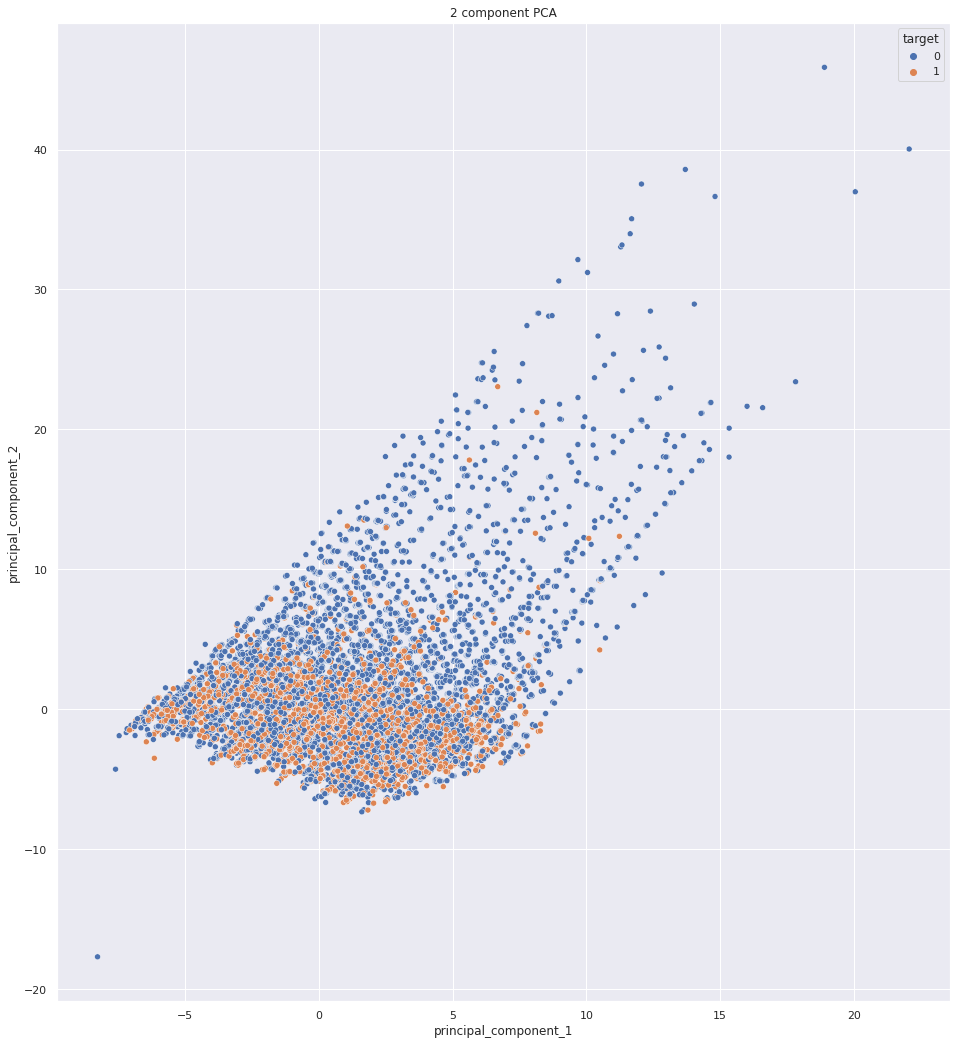

In [23]:
sns.scatterplot(data=finalDf, x='principal_component_1', y='principal_component_2', hue='target')
plt.title('2 component PCA')
plt.show()

## Encoding and Scaling Features

In [24]:
df = train_df.copy()
df.shape

(45211, 17)

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [26]:
df = pd.get_dummies(df,columns = ['job','marital','education','default','housing','month','loan','contact','poutcome'], drop_first = True)
df.head()

,age,balance,day,duration,campaign,pdays,previous,target,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,no,0,0,...,1,0,0,0,0,0,1,0,0,1
1,44,29,5,151,1,-1,0,no,0,0,...,1,0,0,0,0,0,1,0,0,1
2,33,2,5,76,1,-1,0,no,0,1,...,1,0,0,0,1,0,1,0,0,1
3,47,1506,5,92,1,-1,0,no,1,0,...,1,0,0,0,0,0,1,0,0,1
4,33,1,5,198,1,-1,0,no,0,0,...,1,0,0,0,0,0,1,0,0,1


In [27]:
df['target'] = df['target'].map({'no': 0, 'yes':1})
df['target']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: target, Length: 45211, dtype: int64

In [28]:
df.target.value_counts()

0    39922
1     5289
Name: target, dtype: int64

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

columns = df.columns[:-1]

target = df['target']
df = df.drop('target',axis = 1)

df = scaler.fit_transform(df)

df = pd.DataFrame(df,columns=[columns])
df.head()

,age,balance,day,duration,campaign,pdays,previous,target,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,1.511374,-0.310263,-0.128819,-0.113898,-0.436803,-0.262091,1.572395,-0.205972,-0.185948,0.472519
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,1.511374,-0.310263,-0.128819,-0.113898,-0.436803,-0.262091,1.572395,-0.205972,-0.185948,0.472519
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,-0.523740,5.422561,-0.16793,...,1.511374,-0.310263,-0.128819,-0.113898,2.289359,-0.262091,1.572395,-0.205972,-0.185948,0.472519
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,1.909346,-0.184415,-0.16793,...,1.511374,-0.310263,-0.128819,-0.113898,-0.436803,-0.262091,1.572395,-0.205972,-0.185948,0.472519
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,-0.523740,-0.184415,-0.16793,...,1.511374,-0.310263,-0.128819,-0.113898,-0.436803,-0.262091,1.572395,-0.205972,-0.185948,0.472519


In [30]:
target.value_counts()

0    39922
1     5289
Name: target, dtype: int64

### Splitting data into train and test datasets

In [31]:
from sklearn.model_selection import train_test_split

#Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(df,target,test_size = 0.25, random_state = 20)

In [32]:
X_train.columns = X_train.columns.get_level_values(0)
X_test.columns =  X_test.columns.get_level_values(0)

### Testing models

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

kfold = KFold(shuffle=True , random_state=12)

We need to balance classes before testing and learning.

I will use SMOTE to oversample the minority class

In [34]:
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train,y_train)

#### Function for testing models

In [35]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [36]:
from sklearn.model_selection import  learning_curve
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score

In [37]:
classifier = RandomForestClassifier()
classifier.fit(X_train_smote, y_train_smote)
predicted_proba = classifier.predict_proba(X_test)
print(f"ROC AUC score: {roc_auc_score(y_test, predicted_proba[:, 1])}")
pred = classifier.predict(X_test)
print(f"F1 score : {f1_score(y_test, pred)}")
print(classification_report(y_test, pred))

ROC AUC score: 0.9272261713920773
F1 score : 0.5821282906933629
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10001
           1       0.56      0.60      0.58      1302

    accuracy                           0.90     11303
   macro avg       0.76      0.77      0.76     11303
weighted avg       0.90      0.90      0.90     11303



#### Check RandomForest perfomance with learning curves

<module 'matplotlib.pyplot' from '/home/yurii/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

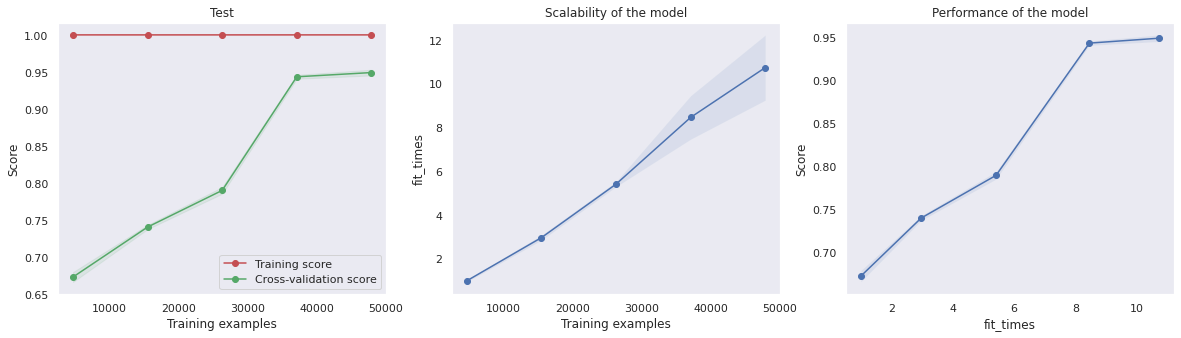

In [38]:
estimator = RandomForestClassifier()
plot_learning_curve(estimator, "Test",X_train_smote, y_train_smote, cv=kfold, n_jobs=-1)

#### LGBM testing

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     10001
           1       0.58      0.63      0.61      1302

    accuracy                           0.91     11303
   macro avg       0.77      0.79      0.78     11303
weighted avg       0.91      0.91      0.91     11303



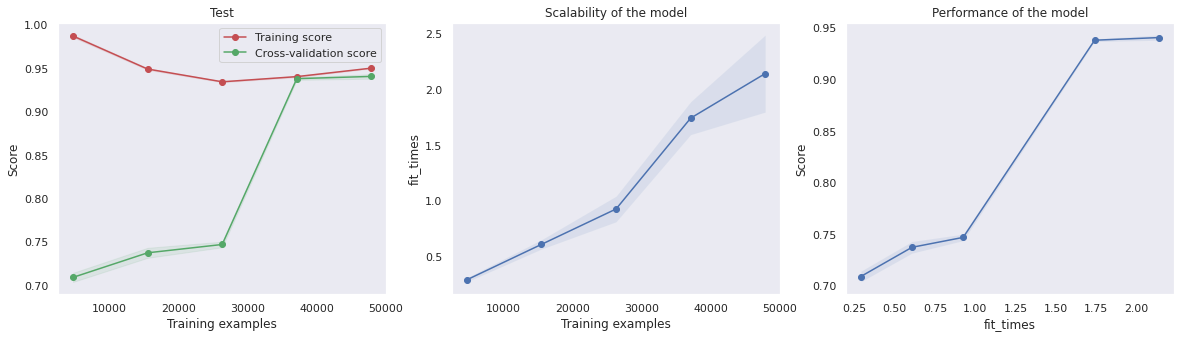

In [39]:
from lightgbm import LGBMClassifier

estimator = LGBMClassifier()
plot_learning_curve(estimator, "Test",X_train_smote, y_train_smote, cv=kfold, n_jobs=-1)
estimator.fit(X_train_smote, y_train_smote)
y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))

#### LGBM have a better results, so i will use it

## Tunning LGBMClassifier

In [40]:
from sklearn.model_selection import GridSearchCV
kfold= KFold(5, shuffle=True, random_state=47)

params = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': range(2,15),
}

estimator = LGBMClassifier()

gr_lgbm = GridSearchCV(estimator, param_grid=params, cv=kfold, n_jobs=-1, verbose=1, scoring='f1')
gr_lgbm.fit(X_train_smote, y_train_smote)
lgbm_depth = gr_lgbm.best_params_
print(f"Best depth: {lgbm_depth['max_depth']}")
print(f"Best boosting_type: {lgbm_depth['boosting_type']}")
print(f"Best score: {gr_lgbm.best_score_}")

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best depth: 12
Best boosting_type: gbdt
Best score: 0.9409420692272924


In [41]:
kfold= KFold(5, shuffle=True, random_state=47)

params = {
    "num_leaves": [2**x for x in range(1, 15)]
}

estimator = LGBMClassifier(max_depth=10)

gr_lgbm = GridSearchCV(estimator, param_grid=params, cv=kfold, n_jobs=-1, verbose=1, scoring='f1')
gr_lgbm.fit(X_train_smote, y_train_smote)
lgbm_leaves = gr_lgbm.best_params_
print(f"Best n_leaves: {lgbm_leaves['num_leaves']}")
print(f"Best score: {gr_lgbm.best_score_}")


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best n_leaves: 128
Best score: 0.9455637838616988


In [42]:
params = {
    "learning_rate": np.linspace(0.009, 0.1)
}

estimator = LGBMClassifier(max_depth=10, num_leaves=256)

gr_lgbm = GridSearchCV(estimator, param_grid=params, cv=kfold, n_jobs=-1, verbose=1, scoring='f1')
gr_lgbm.fit(X_train_smote, y_train_smote)
lgbm_rate = gr_lgbm.best_params_
print(f"Best learning_rate: {lgbm_rate['learning_rate']}")
print(f"Best score: {gr_lgbm.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best learning_rate: 0.09814285714285714
Best score: 0.9455108580690046


<module 'matplotlib.pyplot' from '/home/yurii/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

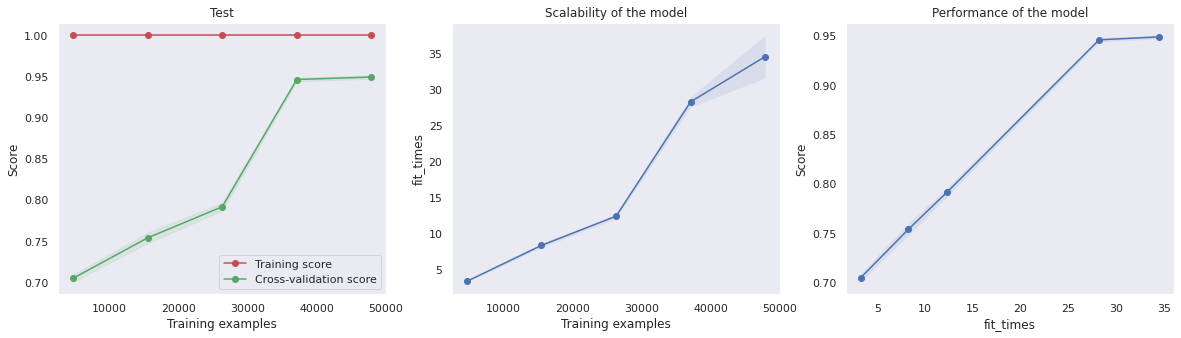

In [43]:
estimator = LGBMClassifier(max_depth=10, num_leaves=256, learning_rate=0.1, n_estimators=1000)
plot_learning_curve(estimator, "Test",X_train_smote, y_train_smote, cv=kfold, n_jobs=-1)

## Training_model

In [44]:
params = {'max_depth':10,'num_leaves':256, 'learning_rate':0.1, 'n_estimators':1000}


estimator =LGBMClassifier(**params)
estimator.fit(X_train_smote, y_train_smote, eval_set=(X_test, y_test), eval_metric='f1', early_stopping_rounds=100, verbose=1)

/home/yurii/anaconda3/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/yurii/anaconda3/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.633016
[2]	valid_0's binary_logloss: 0.584095
[3]	valid_0's binary_logloss: 0.543324
[4]	valid_0's binary_logloss: 0.508138
[5]	valid_0's binary_logloss: 0.478838
[6]	valid_0's binary_logloss: 0.452663
[7]	valid_0's binary_logloss: 0.430944
[8]	valid_0's binary_logloss: 0.411807
[9]	valid_0's binary_logloss: 0.393435
[10]	valid_0's binary_logloss: 0.377624
[11]	valid_0's binary_logloss: 0.363268
[12]	valid_0's binary_logloss: 0.350772
[13]	valid_0's binary_logloss: 0.340077
[14]	valid_0's binary_logloss: 0.329905
[15]	valid_0's binary_logloss: 0.320712
[16]	valid_0's binary_logloss: 0.312957
[17]	valid_0's binary_logloss: 0.304734
[18]	valid_0's binary_logloss: 0.298161
[19]	valid_0's binary_logloss: 0.291828
[20]	valid_0's binary_logloss: 0.286892
[21]	valid_0's binary_logloss: 0.281941
[22]	valid_0's binary_logloss: 0.278288
[23]	valid_0's binary_logloss: 0.27433
[24]	valid_0's binary_logloss: 0.269942
[25]	valid_0's binary_logloss: 0.265952
[26]	valid

LGBMClassifier(max_depth=10, n_estimators=1000, num_leaves=256)

In [45]:
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10001
           1       0.61      0.57      0.59      1302

    accuracy                           0.91     11303
   macro avg       0.78      0.76      0.77     11303
weighted avg       0.91      0.91      0.91     11303



In [46]:
print(f"Final F1 score: {f1_score(y_test, pred)}")

Final F1 score: 0.5878619595398652


## Feature importance

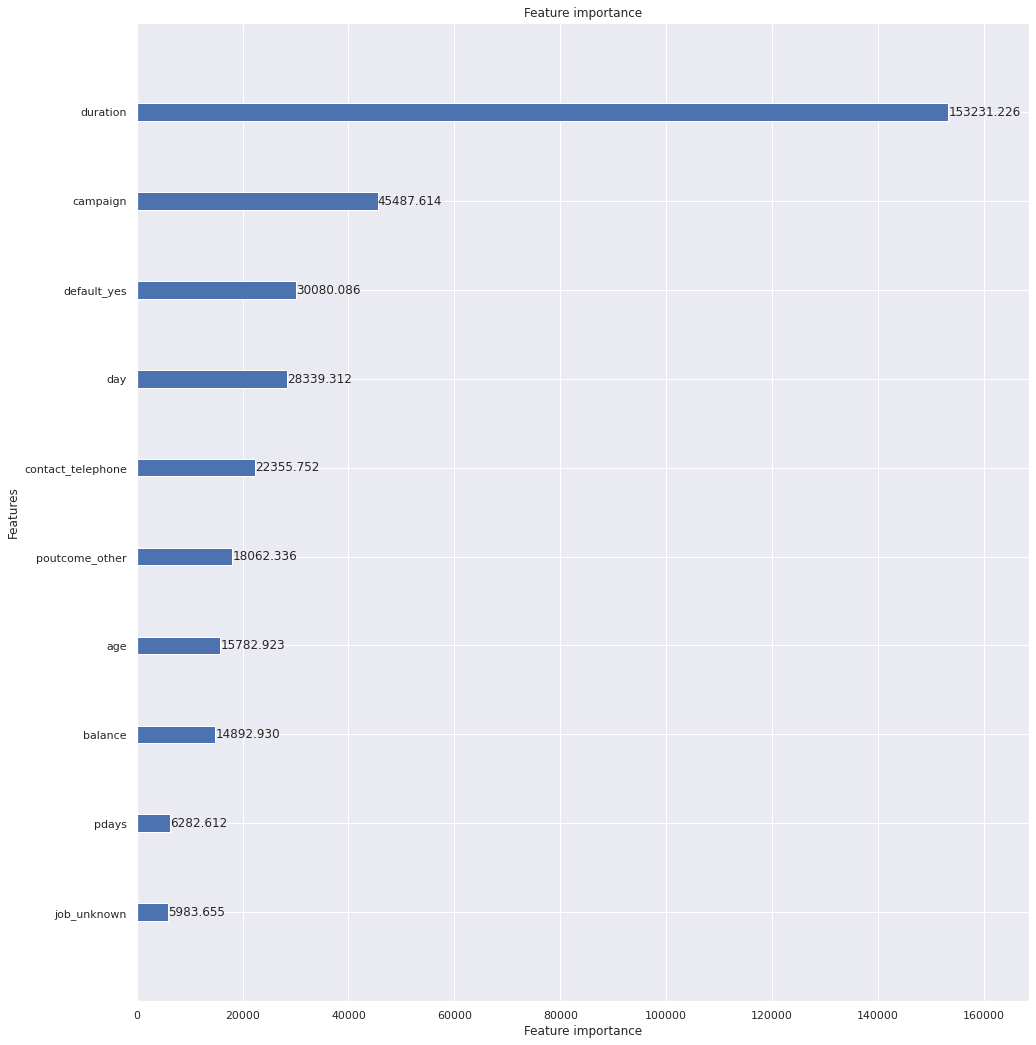

In [53]:
from lightgbm import plot_importance

plot_importance(estimator,max_num_features=10,importance_type='gain')
plt.show()